In [191]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from gtda.diagrams import PersistenceEntropy, Amplitude, NumberOfPoints, ComplexPolynomial, PersistenceLandscape, HeatKernel, Silhouette, BettiCurve, PairwiseDistance, PersistenceImage 
from gtda.plotting import plot_point_cloud
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns
from hausdorff import hausdorff_distance
import numpy as np
import pickle as pickle
import gudhi as gd  
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import norm

%matplotlib inline


# Load data

In [192]:
label_list = [1, 3, 5, 7]

In [230]:
# TS segments for each label
ts_segments = {}

for label in label_list:
    ts_segments[label] = np.load('Data/Segments_for_Label_'+str(label)+'.npy', allow_pickle=True)

In [196]:
# All features
feature_df  = pd.read_csv("Features/All_Features.csv")

In [223]:
# Load embeddings with embedding dimension 3

train_embeddings = {} # dictionary with labels as keys, embeddings of the respective classes as values
test_embeddings = {} # dictionary with labels as keys, embeddings of the respective classes as values

for label in label_list:
    train_embeddings[label] = np.load("Embeddings_and_Persistence_Diagrams/Train_Embeddings_PD"+str(label)+"_Dim3.npy", allow_pickle=True)
    test_embeddings[label] = np.load("Embeddings_and_Persistence_Diagrams/Test_Embeddings_PD"+str(label)+"_Dim3.npy", allow_pickle=True)

In [208]:
# Load persistence diagrams

train_persistence_diagrams = {} # dictionary with labels as keys, persistence diagrams of the respective classes as values
test_persistence_diagrams = {} # dictionary with labels as keys, persistence diagrams of the respective classes as values


for label in label_list:
    train_persistence_diagrams[label] = np.load("Embeddings_and_Persistence_Diagrams/Train_PD"+str(label)+".npy", allow_pickle=True)
    test_persistence_diagrams[label] = np.load("Embeddings_and_Persistence_Diagrams/Test_PD"+str(label)+".npy", allow_pickle=True)


In [199]:
# Load shortened_persistence diagrams

train_shortened_persistence_diagrams = {} # dictionary with labels as keys, persistence diagrams of the respective classes as values
test_shortened_persistence_diagrams = {} # dictionary with labels as keys, persistence diagrams of the respective classes as values


for label in label_list:
    train_shortened_persistence_diagrams[label] = np.load("Embeddings_and_Persistence_Diagrams/Train_Shortened_Diagrams"+str(label)+".npy", allow_pickle=True)
    test_shortened_persistence_diagrams[label] = np.load("Embeddings_and_Persistence_Diagrams/Test_Shortened_Diagrams"+str(label)+".npy", allow_pickle=True)


In [200]:
# Load barycenters

wasserstein_barycenters = [] # dictionary with labels as keys, persistence diagrams of the respective classes as values

for label in label_list:
    wasserstein_barycenters.append(np.load('Embeddings_and_Persistence_Diagrams/wasserstein_Barycenter_class_'+\
                                           str(label)+'.npy', allow_pickle=True)[0])

# Plots directly from Time Series Data

## Plot stacked time series segments of each label directly (partly)

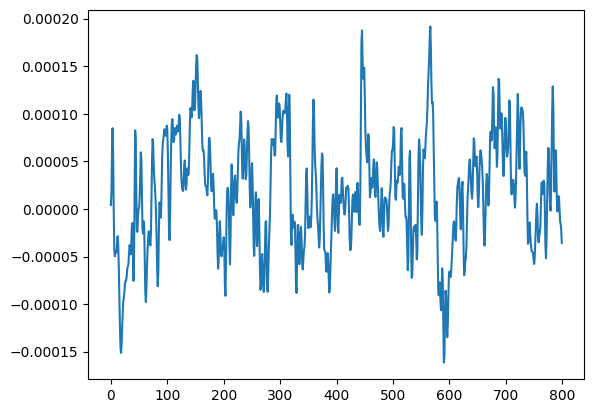

In [254]:
# Choose label 
label = 1

# Plot parts of the time series
plt.plot(ts_segments[label][:800])

# Correlation between Time Series and L1 norm of the signatures

In [245]:
# Choose label
label = 1

## Persistence Landscape

In [246]:
PL = PersistenceLandscape()
L1_norms = []


for diagram in train_persistence_diagrams[label]:
    landscape = PL.fit_transform([diagram])
    L1_norms.append(0.006*norm(landscape[0][0], 1)) # scale TODO later introduce different y axes

In [247]:
ts_segments_means = []

for idx in range(len(L1_norms)):
    # take average of all means
    ts_segments_means.append(np.mean(ts_segments[label][2000*idx:2000*(idx+1)]))

In [248]:
len(ts_segments_means)

591

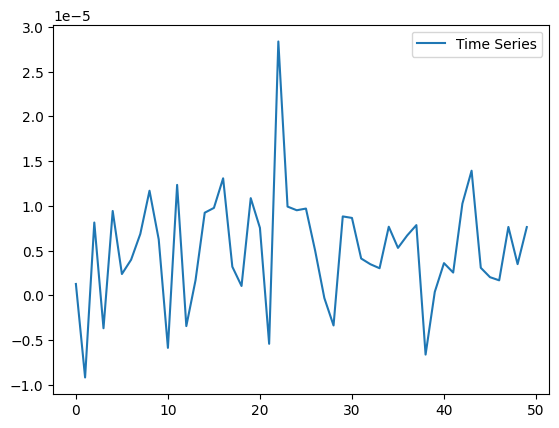

In [234]:
plt.plot(ts_segments_means[:50], label = "Time Series") 
#plt.plot(L1_norms[:50], label = "Scaled L1 norm Persistence Landscape")
plt.legend()
plt.show()

In [222]:
correlation = np.corrcoef(ts_segments_means, L1_norms)[0][1]
print("The correlation is " + str(round(correlation, 5))+".")

The correlation is -0.02815.


# Create simplicial complexes (Experimental)

First, we plot the mean embeddings of each class as point clouds (of which we later want to see the simplicial complexes).

In [99]:
mean_embeddings = {}

for label in label_list:
    all_embeddings = np.concatenate((train_embeddings[label].astype("float"), test_embeddings[label].astype("float")))
    mean_embeddings[label] = np.mean(all_embeddings, axis=0)


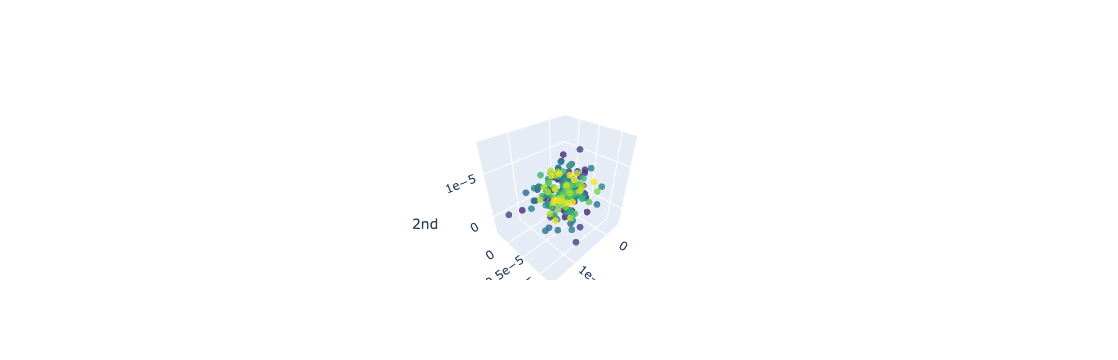

In [100]:
# Label 1
plot_point_cloud(mean_embeddings[1])

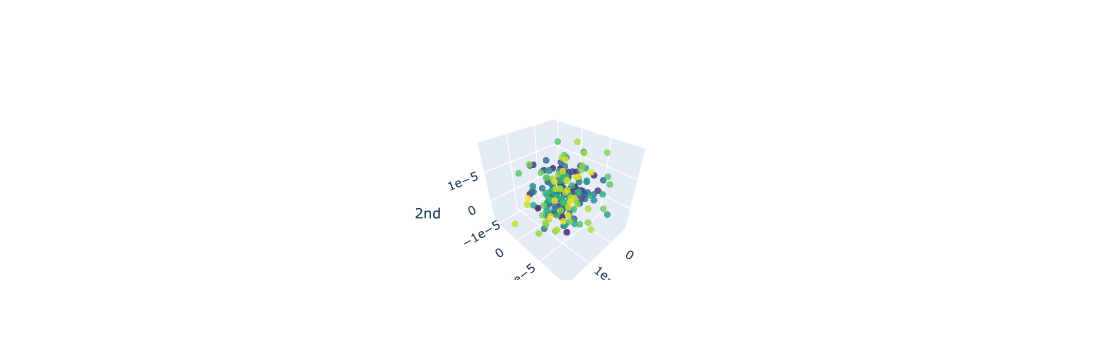

In [101]:
# Label 3
plot_point_cloud(mean_embeddings[3])

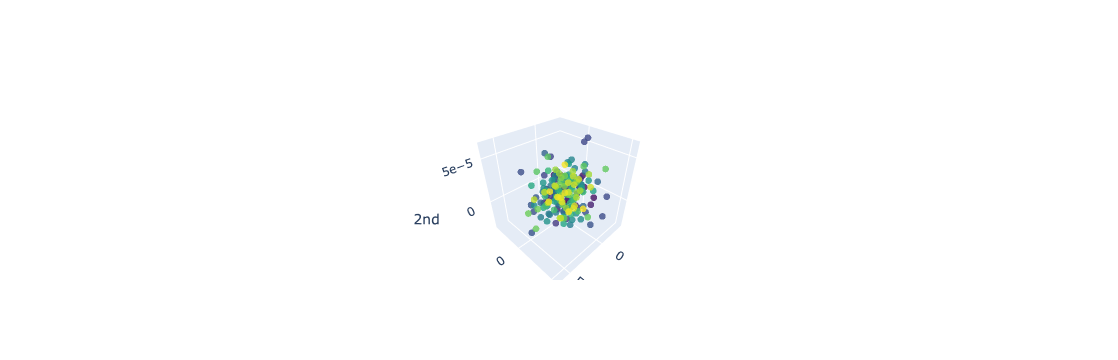

In [102]:
# Label 5
plot_point_cloud(mean_embeddings[5])

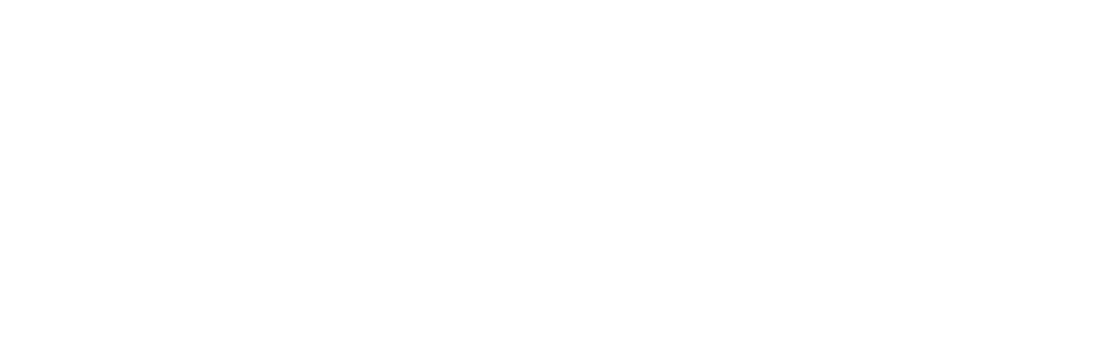

In [103]:
# Label 7
plot_point_cloud(mean_embeddings[7])

Now create simplicial complexes (Vietoris-Rips and alpha complexes) and visualize alpha complexes.

In [104]:
# Label 1
# Vietoris-Rips complex
skeleton = gd.RipsComplex(points = mean_embeddings[1], max_edge_length = 0.2)
Rips_simplex_tree_sample = skeleton.create_simplex_tree(max_dimension = 3) 

# alpha complex
ac = gd.AlphaComplex(points=mean_embeddings[1])
st = ac.create_simplex_tree()

points = np.array([ac.get_point(i) for i in range(st.num_vertices())])
# We want to plot the alpha-complex with alpha=0.005 by default.
# We are only going to plot the triangles
triangles = np.array([s[0] for s in st.get_skeleton(2) if len(s[0]) == 3 and s[1] <= 0.005])

In [ ]:
# Visualization with matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

# TODO does this have a small scaling?
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
l = ax.plot_trisurf(points[:, 0], points[:, 1], points[:, 2], triangles = triangles)

plt.show()

In [ ]:
# Label 7
# Label 1
# Vietoris-Rips complex
skeleton = gd.RipsComplex(points = mean_embeddings[7], max_edge_length = 0.2)
Rips_simplex_tree_sample = skeleton.create_simplex_tree(max_dimension = 3) 

# alpha complex
ac = gd.AlphaComplex(points=mean_embeddings[7])
st = ac.create_simplex_tree()

points = np.array([ac.get_point(i) for i in range(st.num_vertices())])
# We want to plot the alpha-complex with alpha=0.005 by default.
# We are only going to plot the triangles
triangles = np.array([s[0] for s in st.get_skeleton(2) if len(s[0]) == 3 and s[1] <= 0.005])

In [ ]:
# Visualization with matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
l = ax.plot_trisurf(points[:, 0], points[:, 1], points[:, 2], triangles = triangles)

plt.show()

## Gromov Hausdorff distances between the simplicial complexes?

Later look at something like correlations between geometric and topological distances.

In [ ]:
skeleton = []
for s in st.get_skeleton(2):
    skeleton.append(s)

In [ ]:
len(skeleton)

# Dissimilarity matrix of features

## Several features and pairwise label comparison

Does not always make sense because the features have such different scalings. But can make sense for features that, in principle, consist of several columns, like "HK_Vectorization_Dim_xCoord_y"

In [308]:
# Get mean values of the features for each label

mean_df = pd.DataFrame()

for label in label_list:
    filtered_df = feature_df[feature_df["Label"] == label]
    mean_df = pd.concat([mean_df, pd.DataFrame(filtered_df.describe().loc["mean"]).transpose()])
    

Unnamed: 0  Persistence Entropy_Dim_0  Persistence Entropy_Dim_1  \
mean   635.644231                   7.461581                   6.367346   
mean  1201.501905                   7.409825                   6.111013   
mean  1489.000000                   7.426740                   6.292369   
mean  1640.000000                   5.511484                   4.128484   

      Persistence Entropy_Dim_2  Amplitude_Dim_0  Amplitude_Dim_1  \
mean                   4.695868     9.875058e-07     1.037488e-07   
mean                   4.062833     3.242361e-06     2.932656e-07   
mean                   4.480321     1.856573e-06     1.651279e-07   
mean                   3.495342     6.886095e-05     3.351885e-05   

      Amplitude_Dim_2  No_Points_Dim_0  No_Points_Dim_1  No_Points_Dim_2  ...  \
mean     2.574849e-08       189.000000       114.227163        37.724760  ...   
mean     5.297328e-08       189.000000        97.625714        24.837143  ...   
mean     3.668907e-08       189.000000       109.400000        32.577778  ...   
mean     1.966686e-08       144.666667        79.166667        26.166667  ...   

      PL_Vectorization_Dim_2Coord_1  HK_Vectorization_Dim_2Coord_2  \
mean                       0.011556                       0.168791   
mean                       0.011956                       0.167717   
mean                       0.011658                       0.168884   
mean                       0.007699                       0.112508   

      BC_Vectorization_Dim_2Coord_2  SH_Vectorization_Dim_2Coord_2  \
mean                       0.999268                       0.999822   
mean                       0.990698                       0.990843   
mean                       0.999271                       0.999794   
mean                       0.666187                       0.666564   

      PL_Vectorization_Dim_2Coord_2  HK_Vectorization_Dim_2Coord_3  \
mean                       0.981983                      99.681924   
mean                       0.971005                      98.833111   
mean                       0.981695                      99.687104   
mean                       0.654819                      66.455681   

      BC_Vectorization_Dim_2Coord_3  SH_Vectorization_Dim_2Coord_3  \
mean                   4.217335e-39                   5.565497e-16   
mean                   4.486417e-39                   5.779717e-16   
mean                   4.164149e-39                   5.606543e-16   
mean                   2.866287e-39                   3.705088e-16   

      PL_Vectorization_Dim_2Coord_3  Label  
mean                   1.179910e-13    1.0  
mean                   1.365022e-13    3.0  
mean                   1.208812e-13    5.0  
mean                   7.829425e-14    7.0  

[4 rows x 98 columns]

In [327]:
# Look at a set of features

features_list = ["HK_Vectorization_Dim_0Coord_0", "HK_Vectorization_Dim_0Coord_2", "HK_Vectorization_Dim_0Coord_3"]


/var/folders/f_/tyg450s17m53dh3ylrjcmpqc0000gn/T/ipykernel_42490/3748015463.py:3: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead



<Axes: >

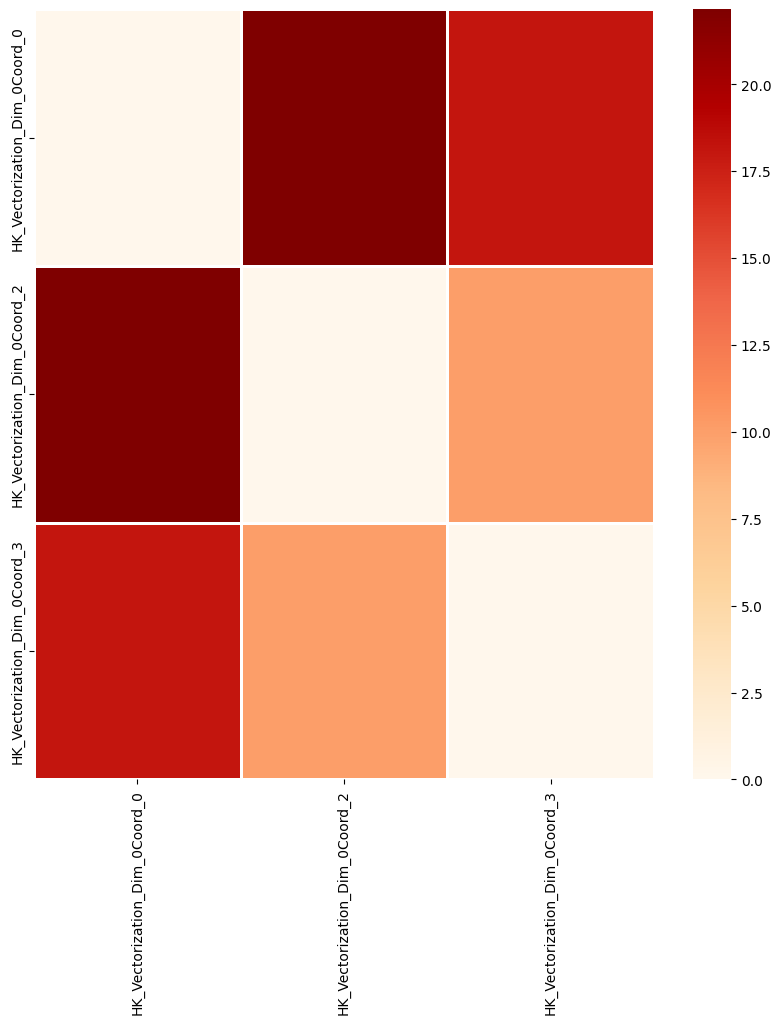

In [328]:
# Distance matrix between label 1 and 3

z = np.array([complex(mean_df[feature][mean_df["Label"] == 1], mean_df[feature][mean_df["Label"] == 3]) for feature in features_list])

m, n = np.meshgrid(z, z)
# get the distance via the norm
distance_matrix = abs(m-n)


# plot it with seaborn
plt.figure(figsize=(10,10))
sns.heatmap(
    distance_matrix,
    cmap='OrRd',
    linewidth=1,
    xticklabels = features_list,
    yticklabels = features_list
)

## One feature and all labels

# Dissimilarity matrix of barycenters

/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/gtda/utils/validation.py:19: FutureWarning:

Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.

/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/gtda/utils/validation.py:19: FutureWarning:

Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.



<Axes: >

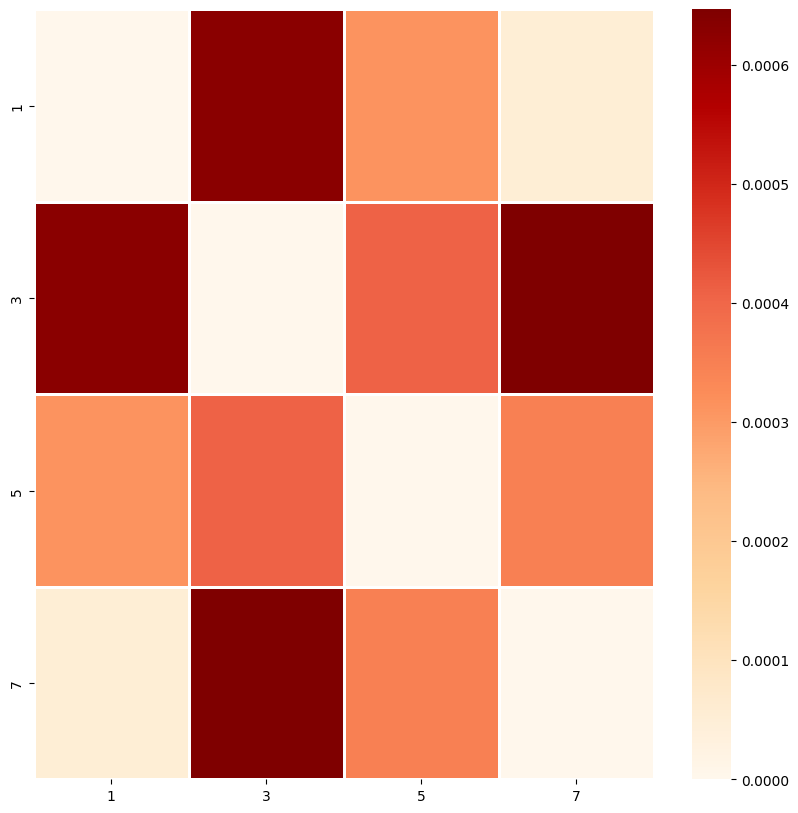

In [310]:
# Wasserstein barycenter
pairwise_distances = PairwiseDistance(metric="wasserstein").fit_transform(wasserstein_barycenters)

# plot it with seaborn
plt.figure(figsize=(10,10))
sns.heatmap(
    pairwise_distances,
    cmap='OrRd',
    linewidth=1,
    xticklabels = [1, 3, 5, 7],
    yticklabels = [1, 3, 5, 7]
)

## Box plots

In [ ]:
#feature_df.columns

In [ ]:
# Choose feature to plot box plot

feature = "AC_coordinate_cc3"

explored_feature = []
explored_feature.append(feature_df[feature][feature_df["Label"] == 1])
explored_feature.append(feature_df[feature][feature_df["Label"] == 3])
explored_feature.append(feature_df[feature][feature_df["Label"] == 5])
#explored_feature.append(feature_df[feature][feature_df["Label"] == 7]) # Changes scaling too much

plt.boxplot(explored_feature)

# show plot
plt.show()

## Heat Kernel

In [ ]:
HK = HeatKernel(sigma=0.00003, n_bins=100)

In [ ]:
def heat_kernel_intensity(heatkernel, homology_dimension):
    """ Computes mean intensity of a heatkernel. Only takes positive values because otherwise the mean would
      always be zero.

    Parameters:
    - heatkernel (list of lists): heatkernel of all homology dimensions
    - homology_dimension (int): Which homology dimension to look at (0, 1 or 2)

    Returns:
    - mean intensity of heatkernel of homology dimension homology_dimension
    """
    
    positives =  [x for inner_list in heatkernel[0][homology_dimension] for x in inner_list if x > 0]
    
    return np.mean(positives)

### Homology dimension 0

#### Label 1

In [ ]:
heatkernel = HK.fit_transform(train_shortened_persistence_diagrams[1])
print("Heat kernel intensity of label 1 for homology dimension 0: " + str(heat_kernel_intensity(heatkernel, 0)))
HK.plot(heatkernel, homology_dimension_idx=0, colorscale='jet')

In [ ]:
heatkernel = HK.fit_transform(train_shortened_persistence_diagrams[3])
print("Heat kernel intensity of label 3 for homology dimension 0: " + str(heat_kernel_intensity(heatkernel, 0)))
HK.plot(heatkernel, homology_dimension_idx=0, colorscale='jet')

In [ ]:
heatkernel = HK.fit_transform(train_shortened_persistence_diagrams[5])
print("Heat kernel intensity of label 5 for homology dimension 0: " + str(heat_kernel_intensity(heatkernel, 0)))

HK.plot(heatkernel, homology_dimension_idx=0, colorscale='jet')

In [ ]:
heatkernel = HK.fit_transform(train_shortened_persistence_diagrams[7])
print("Heat kernel intensity of label 7 for homology dimension 0: " + str(heat_kernel_intensity(heatkernel, 0)))

HK.plot(heatkernel, homology_dimension_idx=0, colorscale='jet')

# Persistence Landscape

In [109]:
PL = PersistenceLandscape()


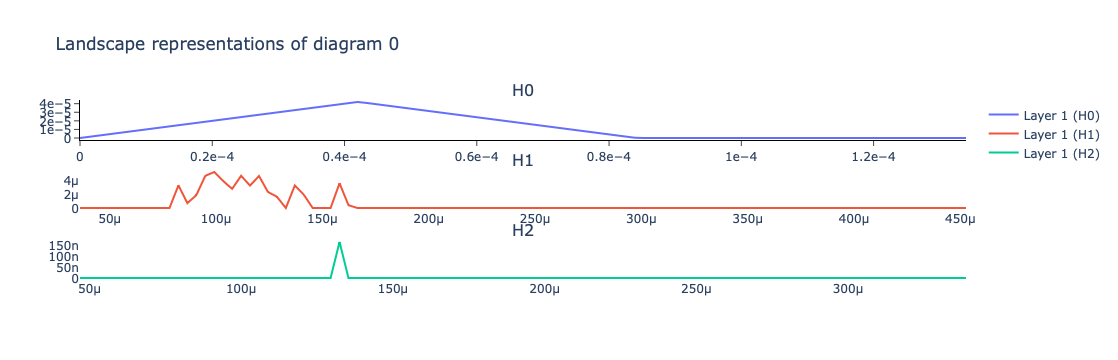

In [110]:
landscape = PL.fit_transform(train_shortened_persistence_diagrams[1])
PL.plot(landscape)

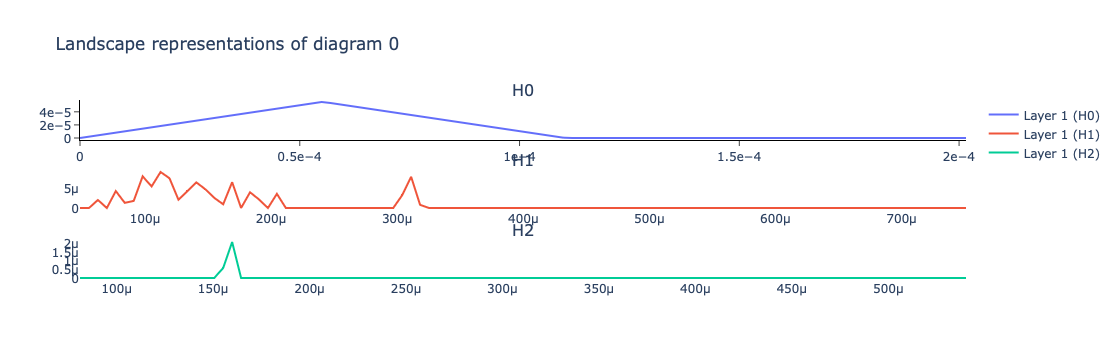

In [111]:
landscape = PL.fit_transform(train_shortened_persistence_diagrams[3])
PL.plot(landscape)

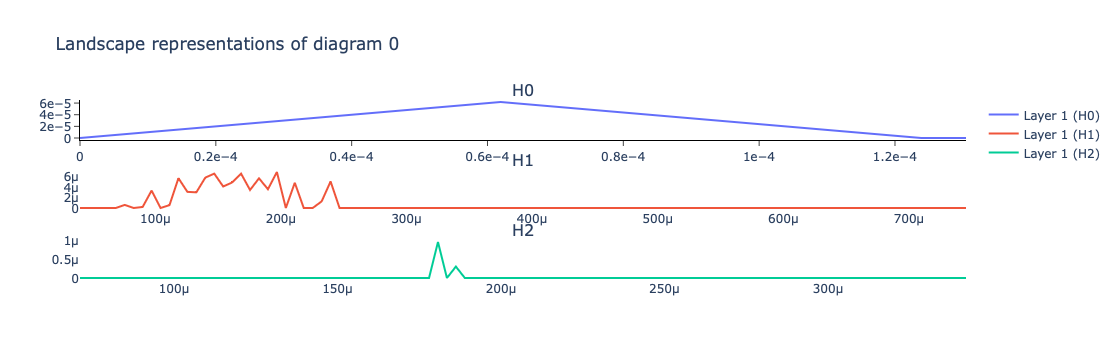

In [112]:
landscape = PL.fit_transform(train_shortened_persistence_diagrams[5])
PL.plot(landscape)


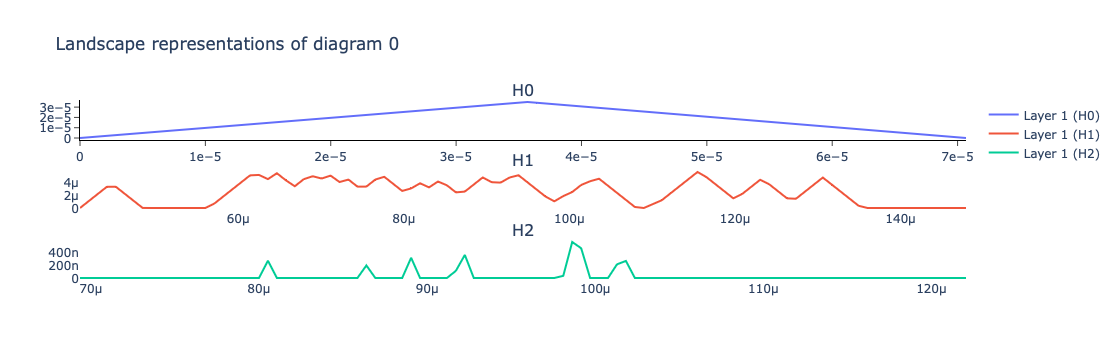

In [113]:
landscape = PL.fit_transform(train_shortened_persistence_diagrams[7])
PL.plot(landscape)

# Silhouette

In [114]:
SH = Silhouette()


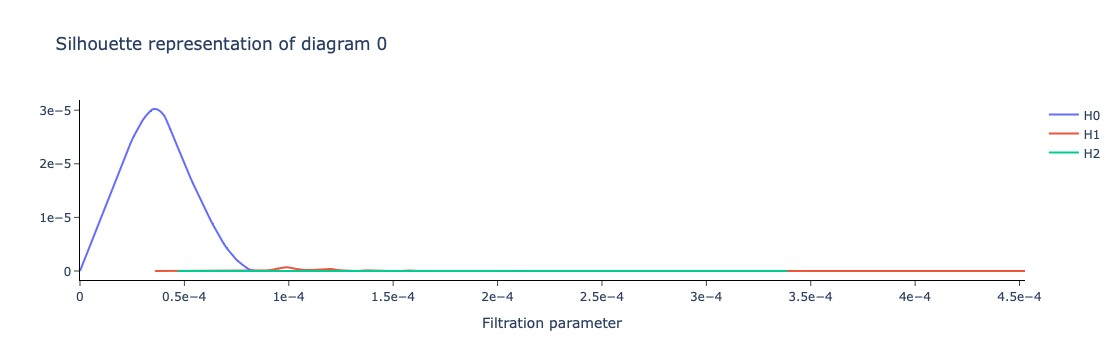

In [115]:
silhouette = SH.fit_transform(train_shortened_persistence_diagrams[1])

SH.plot(silhouette, homology_dimensions = [0, 1, 2])

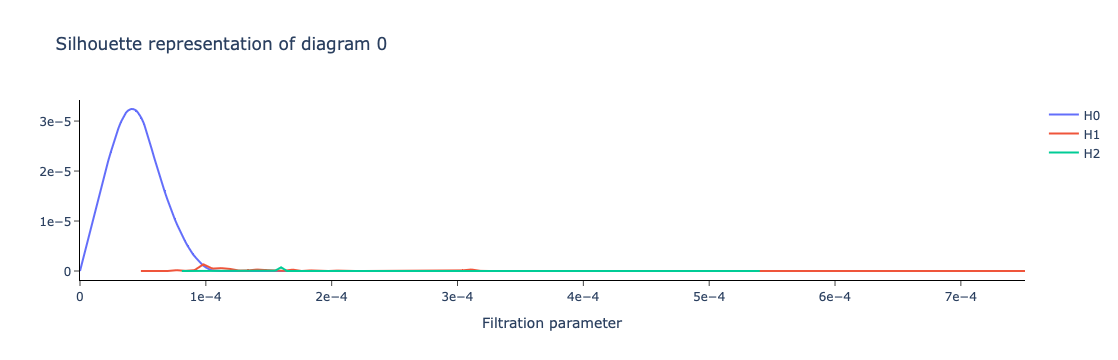

In [116]:
silhouette = SH.fit_transform(train_shortened_persistence_diagrams[3])

SH.plot(silhouette, homology_dimensions = [0, 1, 2])

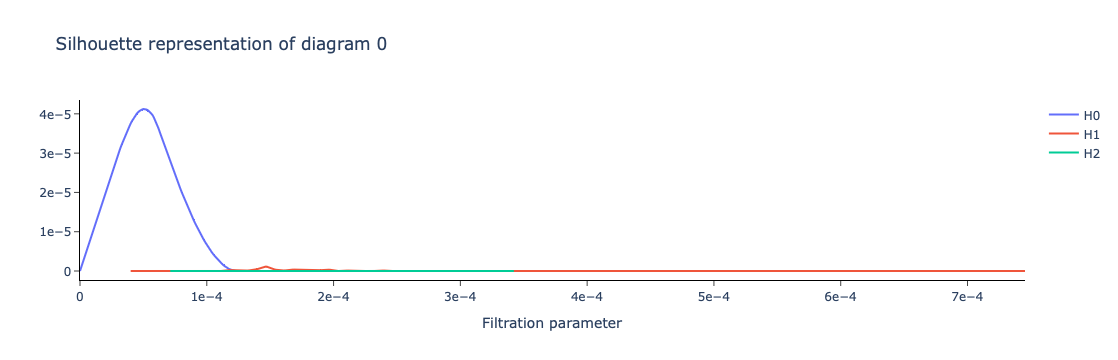

In [117]:
silhouette = SH.fit_transform(train_shortened_persistence_diagrams[5])

SH.plot(silhouette, homology_dimensions = [0, 1, 2])

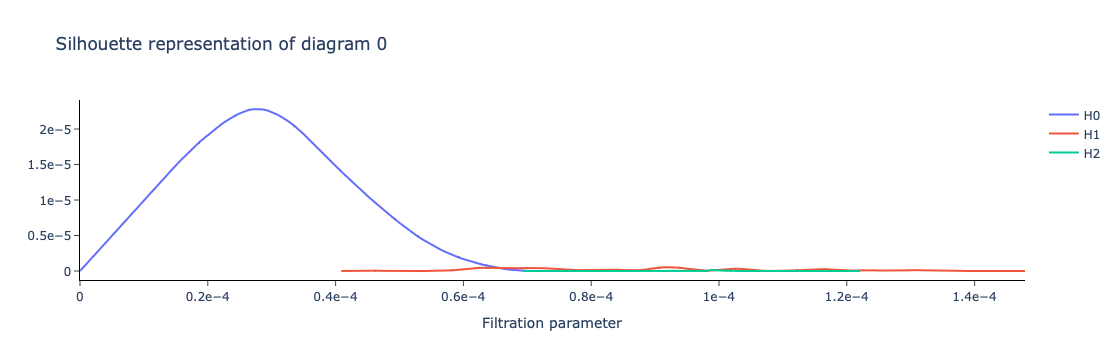

In [118]:
silhouette = SH.fit_transform(train_shortened_persistence_diagrams[7])

SH.plot(silhouette, homology_dimensions = [0, 1, 2])

# Betti Curve

In [119]:
BC = BettiCurve()


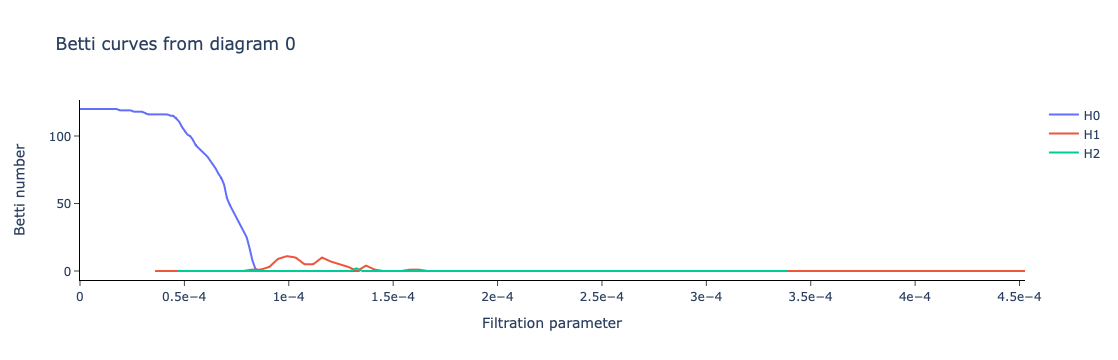

In [120]:
betti_curve = BC.fit_transform_plot(train_shortened_persistence_diagrams[1])

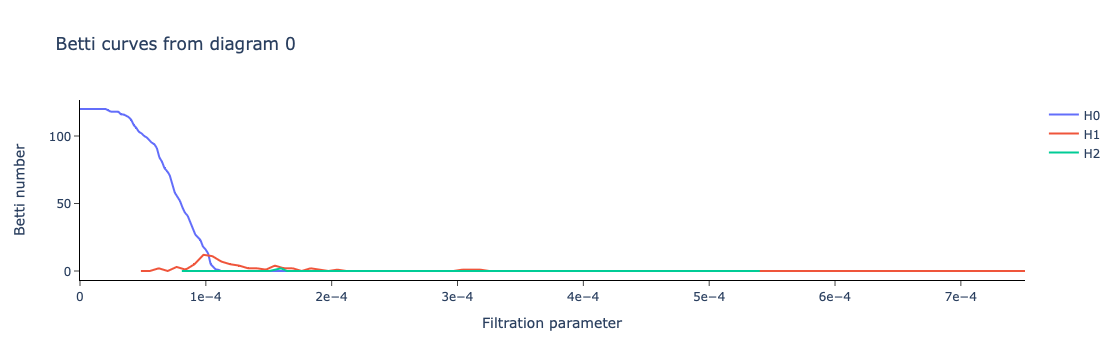

In [121]:
betti_curve = BC.fit_transform_plot(train_shortened_persistence_diagrams[3])

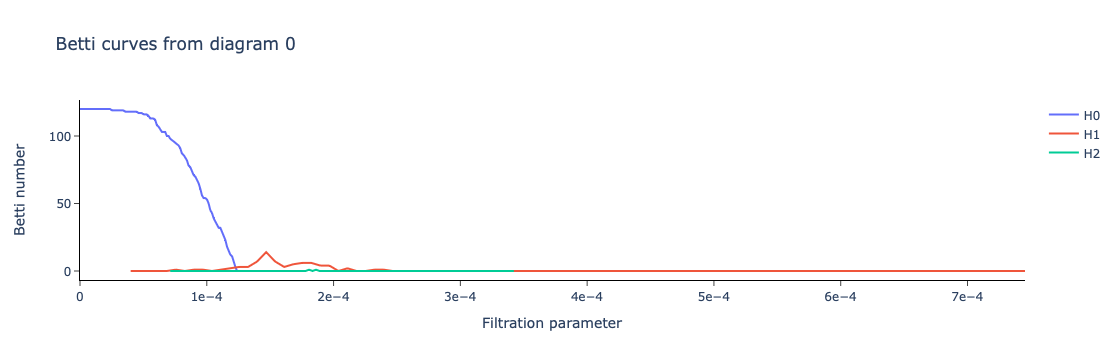

In [122]:
betti_curve = BC.fit_transform_plot(train_shortened_persistence_diagrams[5])

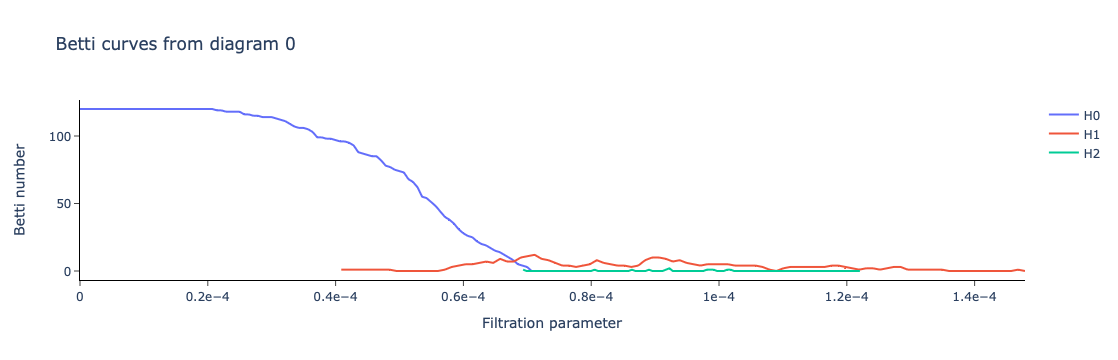

In [123]:
betti_curve = BC.fit_transform_plot(train_shortened_persistence_diagrams[7])

# Persistence Images

In [124]:
PI = PersistenceImage(sigma=0.00003, n_bins=100)

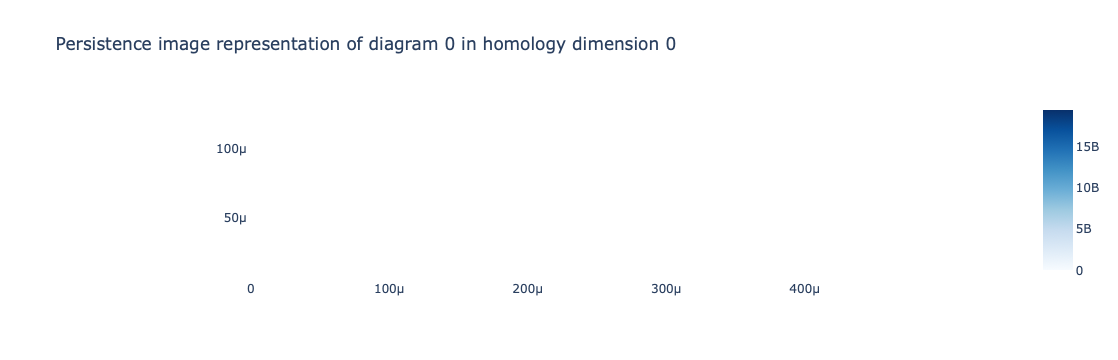

In [125]:
persistence_image = PI.fit_transform_plot(train_shortened_persistence_diagrams[1])

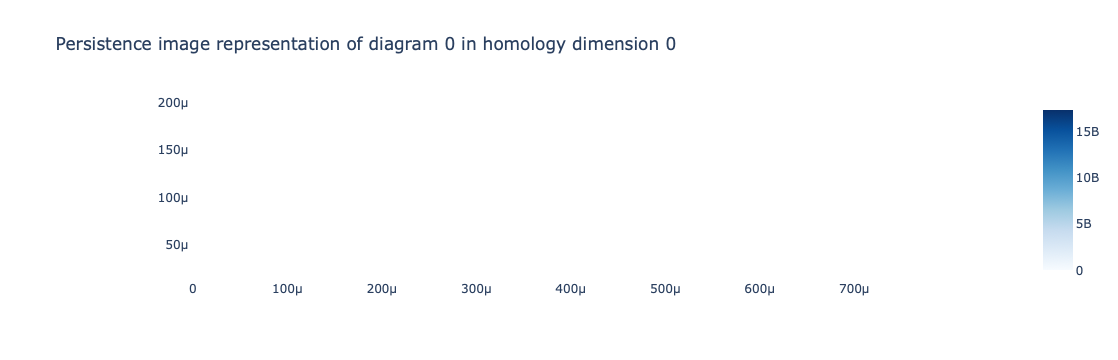

In [126]:
persistence_image = PI.fit_transform_plot(train_shortened_persistence_diagrams[3])

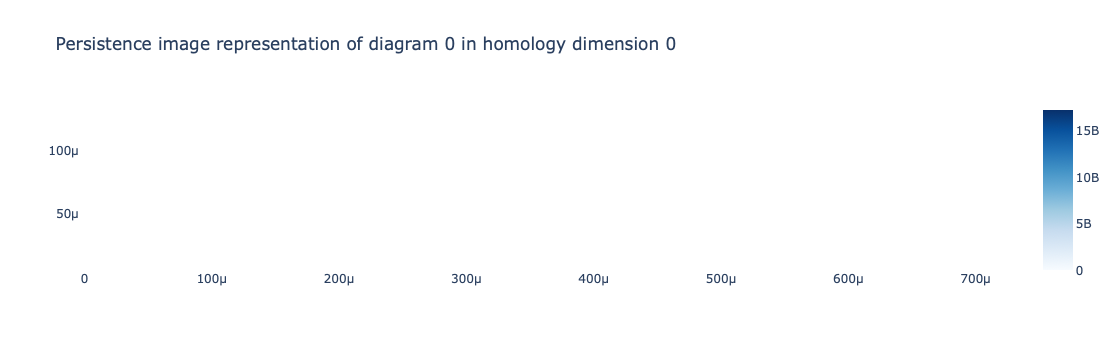

In [127]:
persistence_image = PI.fit_transform_plot(train_shortened_persistence_diagrams[5])

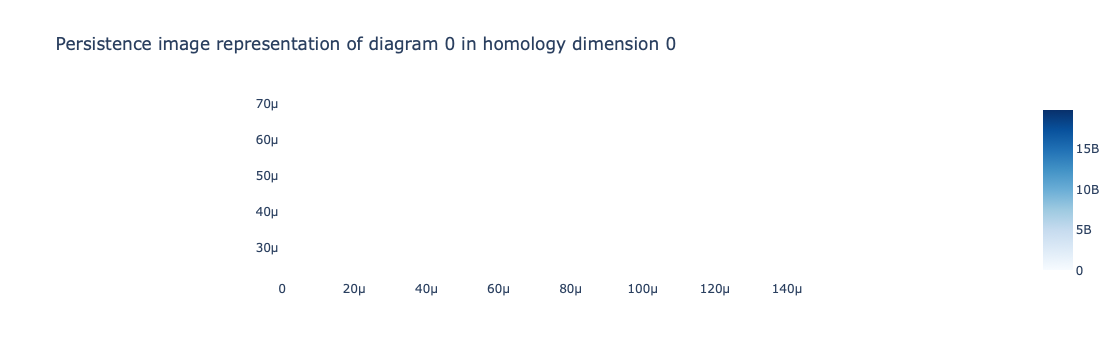

In [128]:
persistence_image = PI.fit_transform_plot(train_shortened_persistence_diagrams[7])